##### need to find if there are periods of the videos where the cricket should be tracked and isn't, seems to be particulartly a problem in the new cohort of mice (these also had the most errors in tracking on talapas)

#### read in dlc tracks, use a version of relentless positivity code to find periods where cricket_tracks=NaN for more than half a second (not sure about this time period, but start with this)

##### use datadirs_newcohort to look through all of the new videos, have it save a dataframe with the filename and an array (or series of arrays) of periods of time where the cricket is missing, can then validate what the video looks like after this

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from copy import deepcopy as cdc

from datetime import datetime as dt
import re
def extract_timestamps(series:pd.Series) -> pd.Series:
    timestamp = series.str.extract('_(\d{4}-[\-\d_T]*)DLC', expand=False)
    return pd.to_datetime(timestamp, format="%Y-%m-%dT%H_%M_%S")
##need to have filename column as type str in order for datetime extraction to be used, won't run on Posix type

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

import prey_capture_python as preycap
# import pandas as pd
import numpy as np
import pathlib as pl
import os
import glob

In [4]:
data_csv = pd.read_csv("/Volumes/Projects/PreyCapture/ZIActivation/DataDirs_newcohort.csv")
new_stem = "/Volumes/Projects/PreyCapture/ZIActivation/"


In [11]:
data_csv

,path,Cond,FatalFlag,Laser,posix_csv_path
0,/Volumes/Projects/PreyCapture/ZIActivation/202...,test,NaN,0.0,/Volumes/Projects/PreyCapture/ZIActivation/202...
1,/Volumes/Projects/PreyCapture/ZIActivation/202...,test,NaN,0.0,/Volumes/Projects/PreyCapture/ZIActivation/202...
2,/Volumes/Projects/PreyCapture/ZIActivation/202...,test,NaN,0.0,NaN
3,/Volumes/Projects/PreyCapture/ZIActivation/202...,test,NaN,0.0,NaN
4,/Volumes/Projects/PreyCapture/ZIActivation/202...,test,NaN,0.0,NaN
...,...,...,...,...,...
1295,/Volumes/Projects/PreyCapture/ZIActivation/202...,9,NaN,1.0,NaN
1296,/Volumes/Projects/PreyCapture/ZIActivation/202...,9,NaN,0.0,NaN
1297,/Volumes/Projects/PreyCapture/ZIActivation/202...,9,NaN,1.0,NaN
1298,/Volumes/Projects/PreyCapture/ZIActivation/202...,9,NaN,0.0,NaN


In [6]:
type(data_csv)

pandas.core.frame.DataFrame

In [42]:
from scipy import signal
from typing import List, Union

def relentless_negativity(df: pd.DataFrame, column:str, window: int = 10, threshold: float = 0.8, tolist:bool = True) -> Union[List[List[int]], np.ndarray]:
    """
    Find ranges where column is missing values for #window number of rows

    Returns:
        List of Lists indicating the start and end of positive ranges
    """
    inds=np.where(df[column].rolling(window).sum()<=threshold*window)[0]
    starts=inds[np.diff(inds, prepend=-1)!=1]-window+1
    # print(starts)
    ends=inds[np.diff(inds, append=-1)!=1]
    # print(ends)
    periods=np.column_stack([starts, ends])
    # print(periods)
    start=np.min(periods)
    # print(start)
    end=np.max(periods)
    # print(end)
    if tolist:
        return periods.tolist(), start, end
    else:
        return periods, start, end

In [43]:
errors=pd.DataFrame(columns=['file','periods','start', 'end'])

for i, row in data_csv.iterrows():
    file = row["path"]
    # print(file)
    path_parts = list(pl.PureWindowsPath(file).parts)
    path_parts = [path_parts[-1]]
    # print(path_parts)
    for path in path_parts:
        # print(path)
        path=str(new_stem+path)
        # print(path)
        ext='csv'
        os.chdir(path)
        try:
            csv=glob.glob('*_filtered.{}'.format(ext))
            csv=str(csv[0])
            # print(csv)
            posix_csv_path=str(path+'/'+csv)
            # print(posix_csv_path)
        except IndexError:
            posix_csv_path=np.nan

    path_parts_og = cdc(path_parts)

    data_csv.at[i, "posix_csv_path"] = posix_csv_path
    # print(posix_csv_path)
    folder_path = pl.Path(*path_parts_og)
    # Do we want to replace SelectedFolders with Posix path instead of Windows?
    if posix_csv_path is not np.nan:
        mouse_xy, cricket_p, cricket_xy, rear_xy, lear_xy, headbase_xy, cricket_front, cricket_back = preycap.extract_points(posix_csv_path,
                                                                                                ['Rear', 'Lear',
                                                                                                 'anteriorC',
                                                                                                 'posteriorC',
                                                                                                 'headbase'])
        try:
            df = pd.DataFrame({'data':cricket_p})
            periods, start, end  = relentless_negativity(df, 'data')
            print(path[-30:])
            errors.at[i,'file']=path[-30:]
            errors.at[i,'periods']=periods
            errors.at[i,'start']=start
            errors.at[i,'end']=end
        except ValueError:
            print("trial '{}' likely has no cricket errors. Please manually check".format(path[-30:]))
        
            

trial '2022-12-07_11-20-50_mouse-1430' likely has no cricket errors. Please manually check
2022-12-07_11-22-51_mouse-1430
2022-12-07_11-28-25_mouse-1430
2022-12-07_11-33-52_mouse-1430
2022-12-07_11-38-49_mouse-1430
2022-12-07_11-43-38_mouse-1430
2022-12-07_11-49-41_mouse-1430
2022-12-07_12-00-33_mouse-1430
2022-12-07_12-53-48_mouse-1430
2022-12-07_12-55-26_mouse-1430
2022-12-07_12-57-23_mouse-1430
2022-12-07_13-00-13_mouse-1430
2022-12-07_13-05-24_mouse-1429
2022-12-07_13-16-51_mouse-1429
2022-12-07_13-19-06_mouse-1429
2022-12-07_13-21-18_mouse-1429
2022-12-07_13-23-53_mouse-1429
2022-12-07_13-25-38_mouse-1429
2022-12-07_13-27-28_mouse-1429
2022-12-07_13-30-18_mouse-1429
2022-12-07_13-32-35_mouse-1429
2022-12-07_13-37-16_mouse-1429
2022-12-07_13-40-05_mouse-1429
2022-12-07_18-06-15_mouse-1336
trial '2022-12-07_18-11-31_mouse-1336' likely has no cricket errors. Please manually check
2022-12-07_18-16-53_mouse-1336
2022-12-07_18-20-57_mouse-1336
2022-12-07_18-26-09_mouse-1336
2022-12-07_1

In [22]:
cricket_front[:,0]

array([   nan,    nan,    nan, ...,    nan,    nan, 821.07])

In [23]:
cricket_xy

[array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan])]

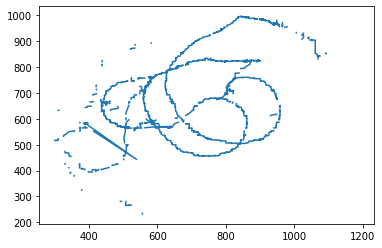

In [24]:
plt.plot(cricket_front[:,0],cricket_front[:,1])


In [26]:
path[-31:]

'/2023-01-29_13-35-41_mouse-1430'

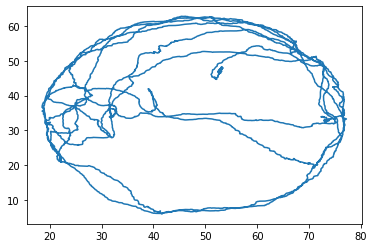

In [25]:
plt.plot(mouse_xy[0], mouse_xy[1])

In [44]:
errors

,file,periods,start,end
1,2022-12-07_11-22-51_mouse-1430,"[[295, 305], [1164, 1174], [1702, 1712], [2539...",295,51897
2,2022-12-07_11-28-25_mouse-1430,"[[1206, 1215], [7112, 7122], [7117, 7132], [51...",1206,51197
3,2022-12-07_11-33-52_mouse-1430,"[[744, 754], [15206, 15219], [21468, 21477], [...",744,41182
4,2022-12-07_11-38-49_mouse-1430,"[[6756, 6767], [12775, 12784], [18676, 18685],...",6756,43581
5,2022-12-07_11-43-38_mouse-1430,"[[6631, 6643], [19014, 19023], [19211, 19223],...",6631,58922
...,...,...,...,...
1295,2023-01-29_13-25-16_mouse-1430,"[[1847, 1856], [3123, 3134], [3333, 3343], [35...",1847,6954
1296,2023-01-29_13-27-15_mouse-1430,"[[3795, 3804]]",3795,3804
1297,2023-01-29_13-29-34_mouse-1430,"[[1937, 1954], [2007, 2018], [2126, 2135], [28...",1937,3036
1298,2023-01-29_13-30-57_mouse-1430,"[[1553, 1565], [1572, 1584], [1602, 1612], [16...",1553,43366
